In [1]:
import scanpy as sc
from glob import glob
import anndata
import scvi
sc.set_figure_params(figsize=(4, 4))

In [2]:
adatas = [sc.read_h5ad(f) for f in glob("../../data/20_scrnaseq_qc/01_qc_and_filtering/**/*.h5ad")]

In [3]:
adata = anndata.concat(adatas, index_unique="_")
adata.layers["raw_counts"] = adata.X.copy()

In [4]:
adata_scvi = adata.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 36827 × 17181
    obs: 'patient', 'timepoint', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes'
    layers: 'raw_counts'

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000, batch_key="patient")

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [7]:
sc.pp.normalize_total(adata)

In [8]:
sc.pp.log1p(adata)

In [9]:
sc.tl.pca(adata)

In [10]:
sc.pp.neighbors(adata)

In [11]:
sc.tl.umap(adata)

In [12]:
sc.tl.leiden(adata)

In [13]:
sc.tl.paga(adata)

... storing 'patient' as categorical
... storing 'timepoint' as categorical
... storing 'sample' as categorical


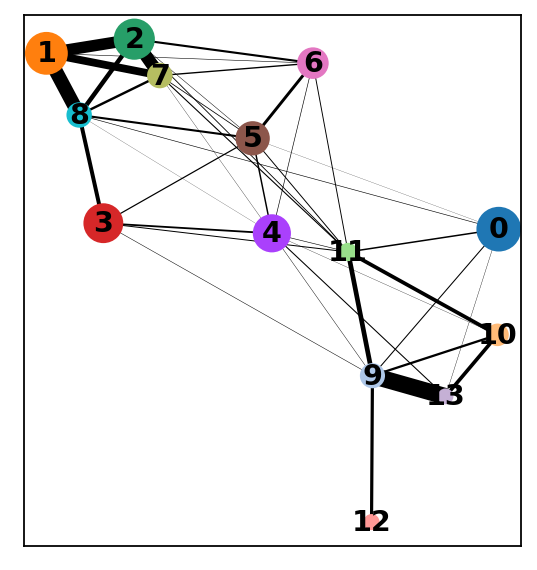

In [14]:
sc.pl.paga(adata)

In [15]:
sc.tl.umap(adata, init_pos="paga")

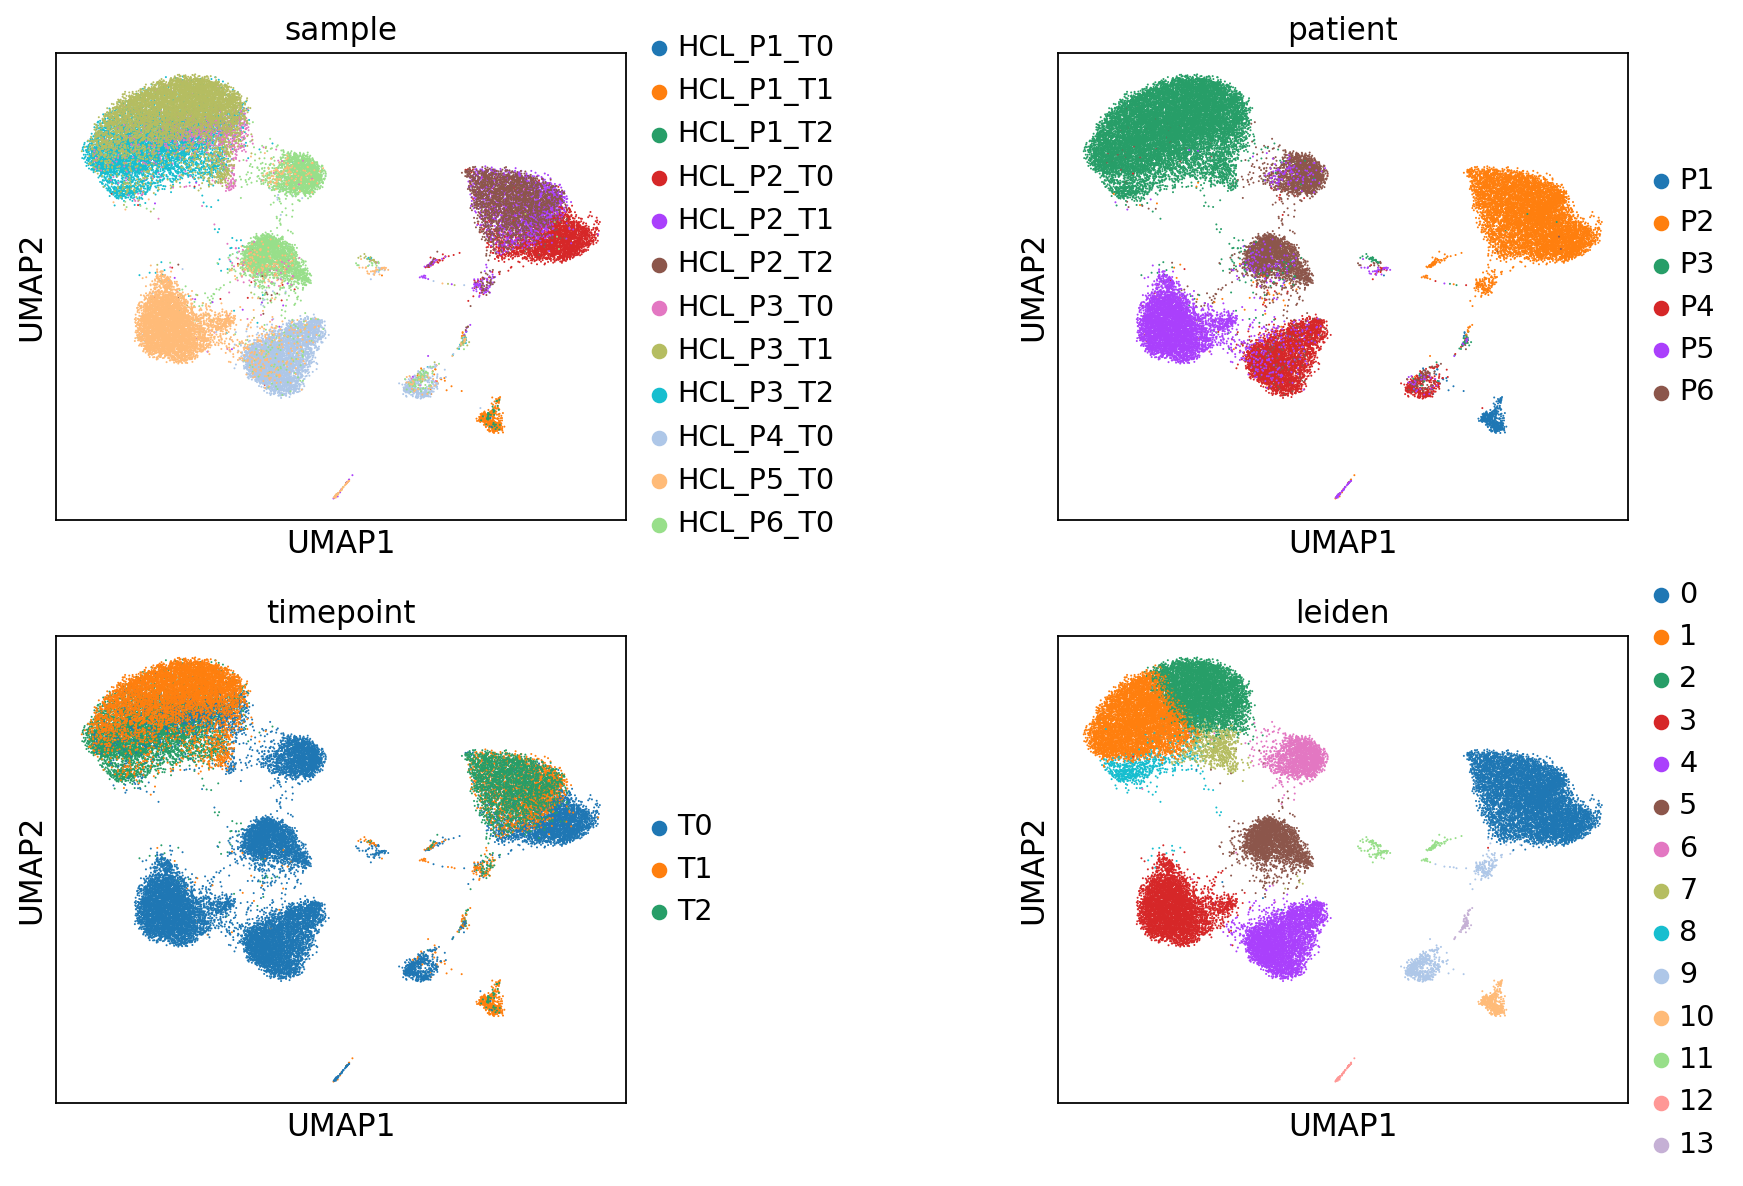

In [16]:
sc.pl.umap(adata, color=["sample", "patient", "timepoint", "leiden"], ncols=2, wspace=.6)

In [17]:
adata.obs["sample"].value_counts()

HCL_P3_T1    6503
HCL_P3_T2    6383
HCL_P5_T0    5426
HCL_P6_T0    4370
HCL_P4_T0    4247
HCL_P2_T0    3431
HCL_P2_T1    2467
HCL_P2_T2    2427
HCL_P3_T0    1120
HCL_P1_T1     411
HCL_P1_T2      40
HCL_P1_T0       2
Name: sample, dtype: int64

# scVI

In [18]:
adata_scvi = adata_scvi[adata_scvi.obs["sample"] != "HCL_P1_T0", :].copy()
adata_scvi._sanitize()

... storing 'patient' as categorical
... storing 'timepoint' as categorical
... storing 'sample' as categorical


In [19]:
sc.pp.highly_variable_genes(adata_scvi, flavor="seurat_v3", n_top_genes=6000, batch_key="patient", subset=True)

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [20]:
scvi.data.setup_anndata(adata_scvi, batch_key="sample")

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 36825 cells, 6000 vars, 11        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [21]:
scvi.data.view_anndata_setup(adata_scvi)

In [22]:
vae = scvi.model.SCVI(adata_scvi, use_cuda=True)

In [23]:
# vae.train()

In [24]:
# vae.save("scvi_model")

In [25]:
vae = scvi.model.SCVI.load("scvi_model", adata=adata_scvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 36825 cells, 6000 vars, 11        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [26]:
adata_scvi.obsm["X_scVI"] = vae.get_latent_representation()

In [27]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.leiden(adata_scvi)
sc.tl.umap(adata_scvi)

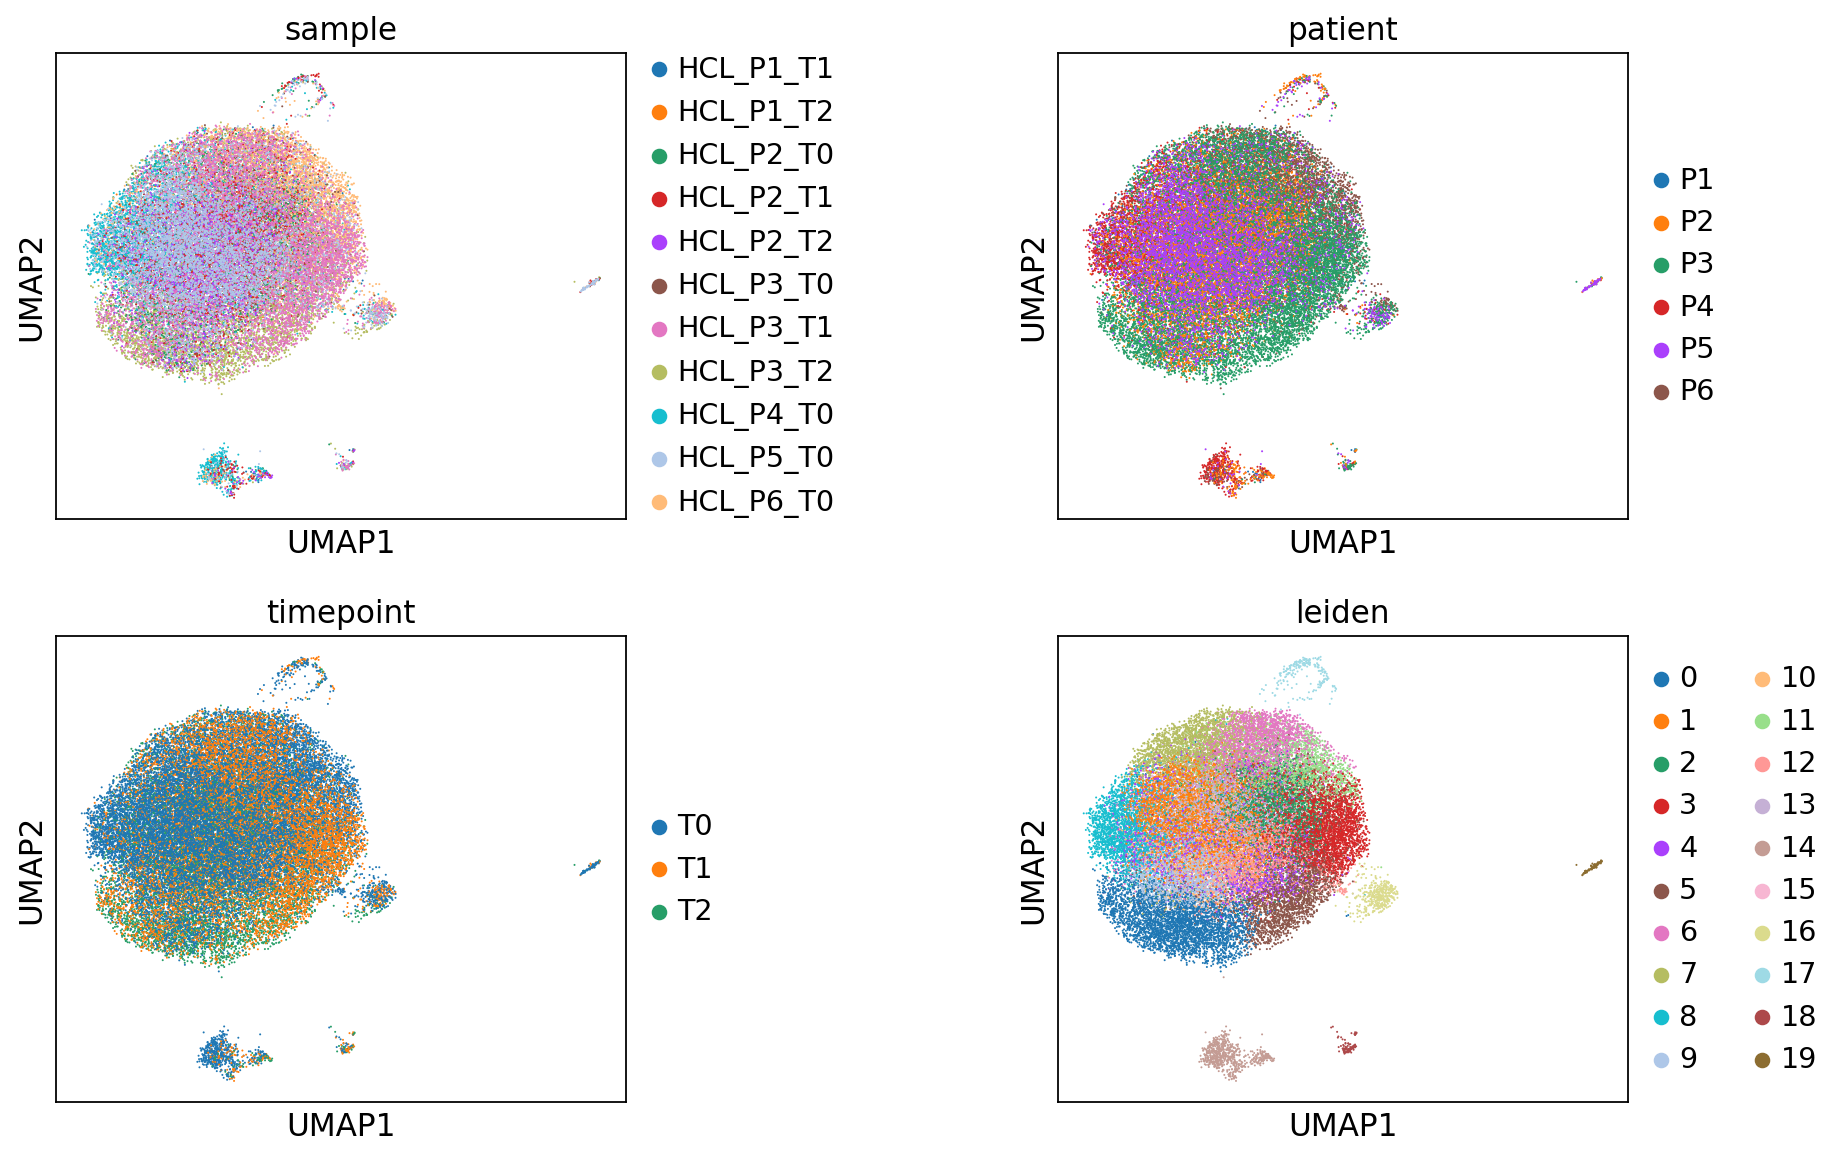

In [28]:
sc.pl.umap(adata_scvi, color=["sample", "patient", "timepoint", "leiden"], ncols=2, wspace=.6)

In [29]:
adata = adata[adata_scvi.obs_names, :].copy()

In [30]:
adata.obsm["X_umap_uncorrected"] = adata.obsm["X_umap"]
adata.obsm["X_umap"] = adata_scvi.obsm["X_umap"]
adata.obsm["X_scVI"] = adata_scvi.obsm["X_scVI"]

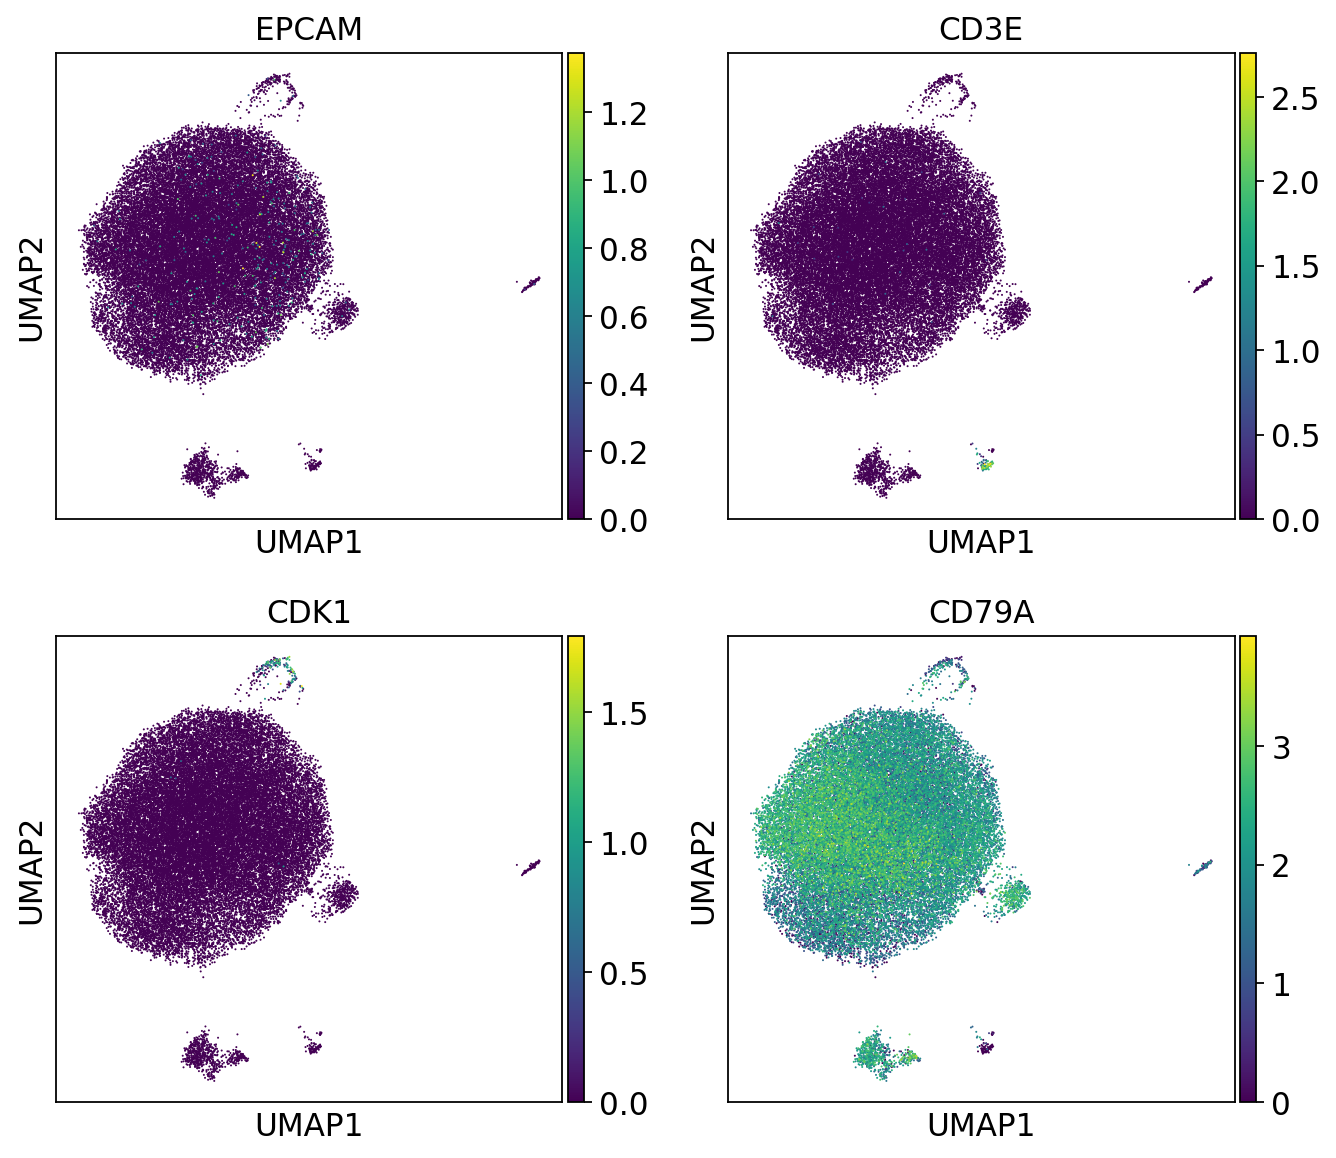

In [31]:
sc.pl.umap(adata, color=["EPCAM", "CD3E", "CDK1", "CD79A"], ncols=2)

In [32]:
!mkdir -p "../../data/30_merge_adata/"

In [33]:
adata.write_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")